In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

In [3]:
item_properties = pd.read_csv('../data/item_properties_master.csv')

In [16]:
numbers_only = item_properties[item_properties.value.str.contains('^n\S*$')]

In [27]:
numbers_only.property.value_counts(normalize=True).sort_values(ascending=False).head()

790    0.774128
663    0.041264
917    0.033709
888    0.019909
810    0.016885
Name: property, dtype: float64

Price appears to be property = 790. Let's check the full data set.

In [28]:
property_790 = item_properties[item_properties.property == '790']

In [33]:
property_790[property_790.value.str.contains('\s')]

,timestamp,itemid,property,value,local_date_time


In [34]:
property_790.value = (property_790.value
                      .str.replace('n','')
                      .astype(float))

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


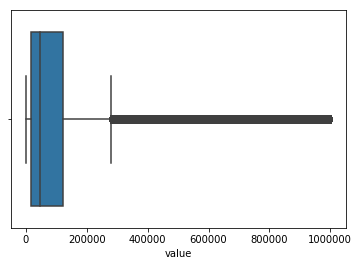

In [53]:
sns.boxplot(property_790[property_790.value < 1e6].value);

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


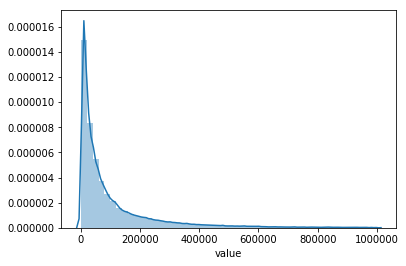

In [51]:
sns.distplot(property_790[property_790.value < 1e6].value);

In [54]:
len(property_790[property_790.value < 1e6].value) / len(property_790.value)

0.9891897084415889

In [2]:
events = pd.read_csv('../data/events.csv')

In [3]:
events = events[events.event == 'addtocart']

In [16]:
visitor_orders = events.groupby('visitorid')['itemid'].count()
visitor_orders[visitor_orders >= 3].shape ## observations

(4129,)

In [43]:
item_orders = events.groupby(['visitorid','itemid'])['event'].count().sort_values(ascending=False)
items_reordered = item_orders[item_orders >= 2].reset_index()

print(f'Number of items re-"added to cart" at least once by a unique visitor: {items_reordered.shape[0]:,}')
print(f'Number of unique visitors who have re-"added to cart": {items_reordered.loc[:,"visitorid"].drop_duplicates().shape[0]:,}')
# sns.distplot(item_orders[item_orders >= 1]);

Number of items re-"added to cart" at least once by a unique visitor: 5,227
Number of unique visitors who have re-"added to cart": 3,732


In [18]:
events_trimmed = pd.read_pickle('../data/events_trimmed.pkl')

events_addtocart = events_trimmed[events_trimmed.event == 'addtocart']

order_history = events_addtocart.loc[:,['session_id', 'visitorid','itemid', 'local_date_time']]

# visitors with multiple sessions only '_1' is alwasy the first session for each visitor
visitors = order_history[~order_history.session_id.str.endswith('_1')].visitorid.unique()
order_history = order_history[order_history.visitorid.isin(visitors)]

# remove dup items which were added twice in the event log
order_history = order_history.groupby(['session_id','visitorid','itemid'])['local_date_time'].max().reset_index()

unique_visitor_item = order_history.loc[:,['visitorid', 'itemid']].drop_duplicates()
total_order_history = unique_visitor_item.merge(order_history, how='outer', on='visitorid')

# Calaculate what was in the cart over time based on what the visitor has ever purchased
total_order_history['in_cart'] = 0

mask = (total_order_history.itemid_y == total_order_history.itemid_x)
total_order_history.loc[mask, 'in_cart'] = 1

# Clean-up columns
total_order_history.drop(columns='itemid_y', inplace=True)
total_order_history.rename(columns={'itemid_x':'itemid'}, inplace=True)

# remove dups where the items are not in the cart (in_cart = 0)
total_order_history['item_session'] = total_order_history.itemid.astype(str) + '_' + total_order_history.session_id
total_order_history[total_order_history.in_cart == 1].item_session.unique()

mask = ((total_order_history.item_session
             .isin(total_order_history[total_order_history.in_cart == 1]
                     .item_session
                     .unique()
                  ))
       & (total_order_history.in_cart == 0))
total_order_history = total_order_history[~mask]
total_order_history = (total_order_history
                       .groupby(['visitorid','itemid','session_id','in_cart','item_session'])['local_date_time']
                       .max()
                       .reset_index())

# calacualte order sequence
total_order_history['seq'] = (total_order_history.session_id
                                        .str.split('_')
                                        .apply(lambda x: x[1])
                                        .astype(int))

total_order_history['order_seq'] = (total_order_history
                                  .groupby('visitorid')['seq']
                                  .rank(method='dense'))

total_order_history.drop(columns='seq',inplace=True)

# split last_order and all other orders
last_order = total_order_history.groupby('visitorid')['session_id'].last()

observations = total_order_history[total_order_history.session_id.isin(last_order)]
prior_observations = total_order_history.drop(observations.index)

print(observations.shape)
print(prior_observations.shape)

(6369, 7)
(153056, 7)


Features:
1.    Time since last order of the item
2.    Number of times the item was ordered in the past
3.    Avg time between adds

In [29]:
observations = pd.read_pickle('../data/observations.pkl')
prior_observations = pd.read_pickle('../data/prior_observations.pkl')
# total_order_history = 

# days since last order and number times an item has been added to the cart
most_recent_order = (prior_observations[prior_observations.in_cart == 1]
                     .groupby(['visitorid','itemid'])['local_date_time']
                     .agg(['max', 'count'])
                     .reset_index())

observations = observations.merge(most_recent_order, on=['visitorid','itemid'], how='left')
observations['days_since_last_order'] = observations.local_date_time - observations['max']
observations['days_since_last_order'] = observations.days_since_last_order.dt.total_seconds()/60/60/24
observations.drop(columns='max', inplace=True)
observations.rename(columns={'count':'add_frequency'}, inplace=True)

# fill gaps, if never re-ordered in history then max days and 0 frequency
observations.days_since_last_order.fillna(observations.days_since_last_order.max(), inplace=True)
observations.add_frequency.fillna(0, inplace=True)

# Average length per add to cart
prior_adds = prior_observations[prior_observations.in_cart == 1].reset_index()
prior_adds['prev_add'] = prior_adds.groupby(['visitorid','itemid'])['local_date_time'].shift(1)
prior_adds['days_prev_add'] = (prior_adds.local_date_time - prior_adds.prev_add).dt.total_seconds()/60/60/24
prior_adds = prior_adds.groupby(['visitorid', 'itemid'])['days_prev_add'].mean().reset_index()
observations = observations.merge(prior_adds, on=['visitorid', 'itemid'], how='left')

observations.days_prev_add.fillna(observations.days_prev_add.max(), inplace=True)

In [30]:
observations.head()

,visitorid,itemid,session_id,in_cart,item_session,local_date_time,order_seq,add_frequency,days_since_last_order,days_prev_add
0,155,41882,155_27539,0,41882_155_27539,2015-09-11 21:38:00.026,2.0,1.0,0.930734,24.055013
1,155,181405,155_27539,0,181405_155_27539,2015-09-11 21:38:00.026,2.0,1.0,0.934168,24.055013
2,155,224623,155_27539,0,224623_155_27539,2015-09-11 21:38:00.026,2.0,1.0,0.929857,24.055013
3,155,368372,155_27539,0,368372_155_27539,2015-09-11 21:38:00.026,2.0,1.0,0.934576,24.055013
4,155,389974,155_27539,1,389974_155_27539,2015-09-11 21:38:00.026,2.0,0.0,32.351154,24.055013


In [4]:
observations[observations.visitorid == 1000306]

,visitorid,itemid,session_id,in_cart,item_session,local_date_time,order_seq
137939,1000306,63543,1000306_37,0,63543_1000306_37,2015-09-04 14:03:50.280,12.0
137951,1000306,102478,1000306_37,0,102478_1000306_37,2015-09-04 14:03:50.280,12.0
137963,1000306,113802,1000306_37,0,113802_1000306_37,2015-09-04 14:03:50.280,12.0
137975,1000306,128296,1000306_37,0,128296_1000306_37,2015-09-04 14:03:50.280,12.0
137987,1000306,220898,1000306_37,0,220898_1000306_37,2015-09-04 14:03:50.280,12.0
137999,1000306,312577,1000306_37,0,312577_1000306_37,2015-09-04 14:03:50.280,12.0
138011,1000306,328756,1000306_37,1,328756_1000306_37,2015-09-04 14:03:50.280,12.0
138023,1000306,434743,1000306_37,0,434743_1000306_37,2015-09-04 14:03:50.280,12.0
138035,1000306,436004,1000306_37,0,436004_1000306_37,2015-09-04 14:03:50.280,12.0
138047,1000306,458271,1000306_37,0,458271_1000306_37,2015-09-04 14:03:50.280,12.0


In [5]:
v = merge_recent.groupby(['visitorid', 'itemid'])['in_cart'].sum()
print(f'Precent of items re-ordered: {len(v[v>0]) / len(v):.2%}')

Precent of items re-ordered: 6.82%


In [26]:
v[v>1]

Series([], Name: in_cart, dtype: int64)

In [6]:
total_order_history[total_order_history.visitorid == 29744].sort_values('order_seq')

,visitorid,itemid,session_id,in_cart,item_session,local_date_time,order_seq
2293,29744,79056,29744_1,1,79056_29744_1,2015-08-21 09:55:56.011,1.0
2295,29744,170943,29744_1,1,170943_29744_1,2015-08-21 10:04:04.744,1.0
2297,29744,264689,29744_1,1,264689_29744_1,2015-08-21 10:05:02.300,1.0
2294,29744,79056,29744_36957,1,79056_29744_36957,2015-09-14 07:39:04.050,2.0
2296,29744,170943,29744_36957,0,170943_29744_36957,2015-09-14 07:39:04.050,2.0
2298,29744,264689,29744_36957,1,264689_29744_36957,2015-09-14 07:38:14.565,2.0


In [162]:
total_order_history[total_order_history.session_id == '1000306_37']

,visitorid,itemid,session_id,local_date_time,in_cart,order_seq
15,1000306,312577,1000306_37,2015-09-04 14:03:34.804,0,12.0
16,1000306,312577,1000306_37,2015-09-04 14:03:50.280,0,12.0
30,1000306,436004,1000306_37,2015-09-04 14:03:34.804,0,12.0
31,1000306,436004,1000306_37,2015-09-04 14:03:50.280,0,12.0
45,1000306,220898,1000306_37,2015-09-04 14:03:34.804,0,12.0
46,1000306,220898,1000306_37,2015-09-04 14:03:50.280,0,12.0
60,1000306,434743,1000306_37,2015-09-04 14:03:34.804,0,12.0
61,1000306,434743,1000306_37,2015-09-04 14:03:50.280,0,12.0
75,1000306,128296,1000306_37,2015-09-04 14:03:34.804,0,12.0
76,1000306,128296,1000306_37,2015-09-04 14:03:50.280,0,12.0


In [ ]:
prior_actual = prior_observations[prior_observations.in_cart == 1]
obs_prior = observations.merge(prior_actual, on=['visitorid','itemid'])
obs_prior['days_since_last_order'] = obs_prior.local_date_time_x - obs_prior.local_date_time_y

In [154]:
obs_prior[obs_prior.visitorid == 737053]

,visitorid,itemid,session_id_x,local_date_time_x,in_cart_x,order_seq_x,session_id_y,local_date_time_y,in_cart_y,order_seq_y,days_since_last_order
6307,737053,199899,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64705,2015-08-29 11:42:38.438,1,1.0,14 days 20:23:00.363000
6308,737053,192653,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64718,2015-08-30 08:57:44.968,1,2.0,13 days 23:07:53.833000
6309,737053,277328,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64722,2015-08-30 11:47:09.036,1,3.0,13 days 20:18:29.765000
6310,737053,315084,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64730,2015-08-30 15:21:08.665,1,4.0,13 days 16:44:30.136000
6311,737053,206317,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64736,2015-08-30 19:29:45.769,1,5.0,13 days 12:35:53.032000
6312,737053,19135,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64752,2015-09-04 15:24:26.518,1,6.0,8 days 16:41:12.283000
6313,737053,314801,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64753,2015-09-04 15:36:26.258,1,7.0,8 days 16:29:12.543000
6314,737053,232744,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64753,2015-09-04 15:43:42.937,1,7.0,8 days 16:21:55.864000
6315,737053,198784,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64754,2015-09-04 16:33:02.164,1,8.0,8 days 15:32:36.637000
6316,737053,187026,737053_64820,2015-09-13 08:05:38.801,0,15.0,737053_64755,2015-09-04 16:56:03.035,1,9.0,8 days 15:09:35.766000


In [153]:
(obs_prior
     .groupby(['visitorid', 'itemid','session_id_x','local_date_time_x', 'order_seq_x'])['days_since_last_order']
      .min())

visitorid  itemid  session_id_x   local_date_time_x        order_seq_x
155        41882   155_27539      2015-09-11 21:38:00.026  2.0            0 days 22:20:15.413000
           181405  155_27539      2015-09-11 21:38:00.026  2.0            0 days 22:25:12.155000
           224623  155_27539      2015-09-11 21:38:00.026  2.0            0 days 22:18:59.631000
           368372  155_27539      2015-09-11 21:38:00.026  2.0            0 days 22:25:47.348000
           442601  155_27539      2015-09-11 21:38:00.026  2.0            0 days 22:20:14.076000
           452082  155_27539      2015-09-11 21:38:00.026  2.0            0 days 22:25:42.443000
3936       61237   3936_43466     2015-08-23 18:50:16.080  2.0            0 days 06:13:09.887000
4537       166106  4537_46800     2015-09-06 18:24:54.607  3.0            0 days 07:14:38.383000
8043       350384  8043_69102     2015-08-20 14:18:15.674  2.0            3 days 01:04:42.895000
8411       392689  8411_71295     2015-09-11 16:35:48.92

In [90]:
total_order_history[total_order_history.visitorid == 737053]

,visitorid,itemid,session_id,local_date_time,in_cart
197973,737053,199899,737053_64705,2015-08-29 11:42:38.438,1
197974,737053,199899,737053_64718,2015-08-30 08:57:44.968,0
197975,737053,199899,737053_64722,2015-08-30 11:47:09.036,0
197976,737053,199899,737053_64730,2015-08-30 15:21:08.665,0
197977,737053,199899,737053_64736,2015-08-30 19:29:45.769,0
197978,737053,199899,737053_64752,2015-09-04 15:24:26.518,0
197979,737053,199899,737053_64753,2015-09-04 15:36:26.258,0
197980,737053,199899,737053_64753,2015-09-04 15:43:42.937,0
197981,737053,199899,737053_64754,2015-09-04 16:33:02.164,0
197982,737053,199899,737053_64755,2015-09-04 16:56:03.035,0


In [67]:
events_trimmed[events_trimmed.session_id == '737053_64705']

,timestamp,visitorid,event,itemid,transactionid,local_date_time,prev_event,session_id,time_diff,page_length
1116675,1440873758438,737053,addtocart,199899,NaN,2015-08-29 11:42:38.438,view,737053_64705,148.047,66.991


In [80]:
property_value = item_properties.loc[:,['itemid','property','value']].drop_duplicates()

In [81]:
property_value.property.value_counts() ## popular properties

790           758982
888           576145
available     484054
categoryid    442432
283           428643
6             422256
678           420884
364           420568
776           417337
159           417053
764           417053
112           417053
202           416446
917           416235
839           398013
227           329360
698           275717
689           211971
28            170106
928           150838
348           110823
1036          105735
810           103712
713            93572
19             74497
400            65396
243            54146
38             54141
46             54141
434            54141
               ...  
427                5
556                5
531                5
872                5
471                4
598                4
1088               4
703                3
58                 3
883                3
968                2
494                2
712                2
1018               2
1027               2
522                1
288          